In [3]:
%matplotlib inline

This notebook explores some of the traits of the sound files presented in the TensorFlow Speech Recognition Challenge.  
The files that are presented in the data set are .wav files that can be processed like so:

Shape: (99, 26)
Sample Data: 16.45911167268467
Shape: (99, 26)
Sample Data: 14.576210289824118
Shape: (99, 26)
Sample Data: 10.808074762398986


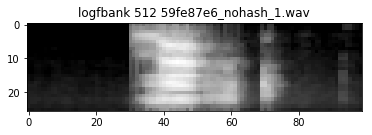

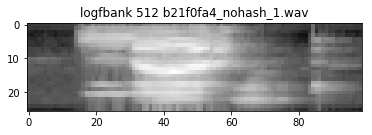

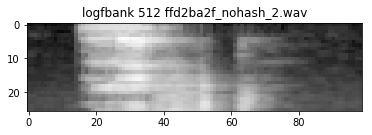

In [2]:
# import scipy.io.wavfile as wav
from python_speech_features import mfcc, logfbank, fbank
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import cm
import scipy.io.wavfile as wav

sample_files = ['59fe87e6_nohash_1.wav','b21f0fa4_nohash_1.wav','ffd2ba2f_nohash_2.wav']

for sample_file in sample_files:
    (rate, sig) = wav.read("/Users/milesporter/Desktop/Kaggle Voice Challenge/model/data/train/audio/left/{0}".format(sample_file))
    
    filter_bank_log_features = logfbank(sig, rate, nfft=1600)
    print("Shape: {0}".format(filter_bank_log_features.shape))
   
    fig, ax = plt.subplots()
    scale = 255.0/ np.amax(filter_bank_log_features)
    filter_bank_log_features = np.swapaxes(filter_bank_log_features, 0 ,1)
    img = Image.fromarray(filter_bank_log_features * scale)
        
    print("Sample Data: {0}".format(filter_bank_log_features[10,40]))
    cax = ax.imshow(img)
    ax.set_title('logfbank 512 {0}'.format(sample_file))

plt.show()


Here we can see a couple things:

- First the MFCCs are all 26x99.  This is true for the MFCC for log bank features.  If we just did the mfcc (Mel frequency capstrial coefficients) we would have arrays that are 13x99.    
- In order to normalize the data, we can scale it so that it runs from 0 to 255.  This may have the affect of boosting noise, but I think that it might make sense to get everything at the same level.
- There is a bunch of blank space at the beginning of the files, and some at the end of the last one.  I am not sure if I will need to filter that out as well.

After adjusting the model so that I am using a modified cifar-10 architecture  (Note:  input_shape == (26,99,1) )

<pre>
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(output_length))
        model.add(Activation('softmax'))

        #sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov = True)

        # Train model

        #model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        # initiate RMSprop optimizer
        opt = optimizers.rmsprop(lr=0.00005, decay=1e-6)

        # Let's train the model using RMSprop
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
</pre>
  
We get the following results:
  
<img src="files/GoodGuessKaggleCnn.png"/>
  

# Multiple nets...

I have had some success in training networks based on the 10 known words.  That approach has resulted in an accuracy of around 60%.  However, one issue that I have had is that the test set also contains words that are outside of the 10 known words..  Also the set contains some files that just include background noise.

My thinking lately has been to use an approach that involves training nets that simply identify a file either as a matching word, or as "other".  Then I will run each word through the collection of 10 nets to see if it matches any of them.  I will also use a simple approach to determine if a word is just noise by seeing if the MFCC has a standard deviation of below some threshold.  To see how that could work, let's compute the standard deviation for a few of the "silence" words.  Based on the experiment below, it looks like we could go with a value of around 1.5 for that standard deviation.


Shape: (99, 26)
Max: 28748
Sample Data: 18.4332173936


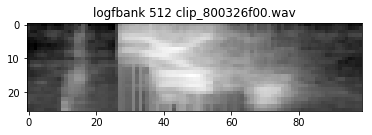

Shape: (99, 26)
Max: 365
Sample Data: 9.19439146706


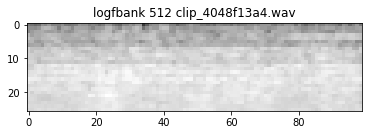

In [7]:
# import scipy.io.wavfile as wav
from python_speech_features import mfcc, logfbank, fbank
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import cm
import scipy.io.wavfile as wav

               #    "Right"             "Silence" 
sample_files = ['clip_800326f00.wav','clip_4048f13a4.wav']

for sample_file in sample_files:
    (rate, sig) = wav.read("/Users/milesporter/Desktop/Kaggle Voice Challenge/data/test/audio/{0}".format(sample_file))
    
    filter_bank_log_features = logfbank(sig, rate, nfft=1600)
    print("Shape: {0}".format(filter_bank_log_features.shape))
   
    fig, ax = plt.subplots()
    scale = 255.0/ np.amax(filter_bank_log_features)
    s = np.max(sig)
    print("Max: {0}".format(s))
    filter_bank_log_features = np.swapaxes(filter_bank_log_features, 0 ,1)
    img = Image.fromarray(filter_bank_log_features * scale)
        
    print("Sample Data: {0}".format(filter_bank_log_features[10,40]))
    cax = ax.imshow(img)
    ax.set_title('logfbank 512 {0}'.format(sample_file))
    plt.show()
